In [61]:
import os
import pandas as pd
import numpy as np
import gzip
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import numpy as np
from sklearn.preprocessing import StandardScaler
import yaml
import pandas as pd
import gzip
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [62]:
wd_dir = '/beegfs/scratch/ric.broccoli/kubacki.michal/GSE98969'
os.chdir(wd_dir)

In [63]:
sharon_dir = '/beegfs/scratch/ric.broccoli/kubacki.michal/Sharon_RNA/samples/all/runs/all/fastq/merge-by-read/trimmed/trimmomatic/mapped/STAR/merged/featureCounts/merged'

# Local Functions

In [64]:
def load_yaml_file(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

def load_counts_data(counts_file):
    with gzip.open(counts_file, 'rt') as f:
        counts_data = pd.read_csv(f, sep='\t')
    return counts_data

def load_geo_data(file_path):
    with gzip.open(file_path, 'rt') as f:
        data = pd.read_csv(f, sep='\t', index_col=0)
    return data

def process_counts_data(counts_data):
    counts_matrix = counts_data.set_index('Geneid')
    sample_columns = counts_matrix.columns[5:]
    counts_matrix = counts_matrix[sample_columns]
    return counts_matrix

def unified_rnaseq_processing(data, is_counts=True):
    if is_counts:
        # For count data (sharon), first convert to CPM
        data = data.apply(lambda x: x / x.sum() * 1e6, axis=0)
    
    # Log2 transform (add small value to avoid log(0))
    data_log2 = np.log2(data + 1)
    
    # Filter low-expression genes
    data_filtered = data_log2[data_log2.mean(axis=1) > 1]
    
    # Scale the data
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data_filtered.T).T,
                               index=data_filtered.index,
                               columns=data_filtered.columns)
    
    return scaled_data, data_filtered

def create_distribution_plots(data, title_prefix, save_to_file=False):
    # Boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data)
    plt.title(f"{title_prefix} - Boxplot of Gene Expression")
    plt.xlabel("Samples")
    plt.ylabel("Expression")
    plt.xticks(rotation=90)
    plt.tight_layout()
    if save_to_file:
        plt.savefig(f"{title_prefix.lower().replace(' ', '_')}_boxplot.png")
        plt.close()
    else:
        plt.show()

    # Density plot
    plt.figure(figsize=(12, 6))
    for column in data.columns:
        sns.kdeplot(data=data[column], label=column)
    plt.title(f"{title_prefix} - Density Plot of Gene Expression")
    plt.xlabel("Expression")
    plt.ylabel("Density")
    plt.tight_layout()
    if save_to_file:
        plt.savefig(f"{title_prefix.lower().replace(' ', '_')}_density.png")
        plt.close()
    else:
        plt.show()

# GSE98969 data


## Load GSE98969 data

In [65]:
# Load DAM data from GSE98969 and aggregate to bulk-like samples
dam_files = [os.path.join("./data", f) for f in os.listdir("./data") if f.endswith('.txt.gz') and f.startswith('GSM')]
dam_data_list = []
for file in dam_files:
    sample_data = load_geo_data(file)
    sample_name = os.path.basename(file).split('_')[0]  # Use GSM ID as sample name
    # Sum expression across all cells to create a bulk-like sample
    bulk_like_sample = sample_data.sum(axis=1)
    dam_data_list.append(pd.DataFrame(bulk_like_sample, columns=[sample_name]))

dam_data = pd.concat(dam_data_list, axis=1)

In [66]:
# Save dam_data to a CSV file
output_file = os.path.join(wd_dir, 'output', "dam_data.csv")
dam_data.to_csv(output_file)
print(f"Saved dam_data to {output_file}")

Saved dam_data to /beegfs/scratch/ric.broccoli/kubacki.michal/GSE98969/output/dam_data.csv


In [67]:
dam_data.head()

,GSM2629433,GSM2629365,GSM2629414,GSM2629390,GSM2629354,GSM2629393,GSM2629427,GSM2629341,GSM2629421,GSM2629368,...,GSM2629372,GSM2629377,GSM2629348,GSM2629352,GSM2629398,GSM2629416,GSM2629438,GSM2629410,GSM2629397,GSM2629344
0610005C13Rik,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,2,1,0
0610007C21Rik,53,40,28,70,46,65,37,61,33,85,...,110,19,79,61,50,39,62,38,39,92
0610007L01Rik,23,36,14,29,23,26,42,18,20,22,...,28,22,27,20,35,17,25,19,19,27
0610007P08Rik,0,0,5,8,3,11,5,12,1,5,...,9,4,12,5,3,3,0,3,7,14
0610007P14Rik,9,14,6,4,8,17,16,2,13,14,...,24,22,15,11,6,6,6,10,15,22


## Filter GSE98969 data

In [68]:
# Process DAM data
# The DAM data, being derived from single-cell RNA-seq, is likely already normalized in some way (possibly as TPM or RPKM)
dam_processed, dam_filtered = unified_rnaseq_processing(dam_data, is_counts=False)

In [69]:
# Save dam_data to a CSV file
output_file = os.path.join(wd_dir, 'output', "dam_processed.csv")
dam_processed.to_csv(output_file)
print(f"Saved dam_processed to {output_file}")

# Save dam_data to a CSV file
output_file = os.path.join(wd_dir, 'output', "dam_filtered.csv")
dam_filtered.to_csv(output_file)
print(f"Saved dam_filtered to {output_file}")

Saved dam_processed to /beegfs/scratch/ric.broccoli/kubacki.michal/GSE98969/output/dam_processed.csv
Saved dam_filtered to /beegfs/scratch/ric.broccoli/kubacki.michal/GSE98969/output/dam_filtered.csv


# Sharon data

## Load Sharon data

In [70]:
sharon_counts_file = os.path.join(sharon_dir, "all.counts.gz")
sharon_counts_data = load_counts_data(sharon_counts_file)

In [71]:
sharon_counts_data.head()

,Geneid,Chr,Start,End,Strand,Length,REMI_a_ADP_1,REMI_a_AGW5_1,REMI_a_ADW5_1,REMI_a_AG_3,...,REMI_m_AGW5_1,REMI_m_AGW5_2,REMI_a_AGP_1,REMI_m_ADW5_4,REMI_m_AGW5_4,REMI_a_AGW_1,REMI_a_ADP_2,REMI_a_AGP_2,REMI_m_ADW5_3,REMI_a_ADW5_2
0,4933401J01Rik,chr1,3073253,3074322,+,1070,0,0,18,0,...,2,6,4,7,0,0,26,16,0,5
1,Gm26206,chr1,3102016,3102125,+,110,0,0,0,0,...,0,0,0,2,0,0,0,1,0,0
2,Xkr4,chr1;chr1;chr1,3214482;3421702;3670552,3216968;3421901;3671498,-;-;-,3634,12,102,176,50,...,8,13,22,16,6,177,34,42,4,95
3,Gm18956,chr1,3252757,3253236,+,480,0,0,0,0,...,2,0,0,1,0,0,2,1,0,0
4,Gm37180,chr1,3365731,3368549,-,2819,7,4,51,2,...,28,32,2,21,14,0,16,17,12,0


In [72]:
sharon_bulk_counts = process_counts_data(sharon_counts_data)

In [73]:
# Display information about the matrix
print("\nMatrix shape:", sharon_bulk_counts.shape)
print("Number of genes:", sharon_bulk_counts.shape[0])
print("Number of samples:", sharon_bulk_counts.shape[1])


Matrix shape: (55376, 30)
Number of genes: 55376
Number of samples: 30


In [74]:
sharon_bulk_counts.head()

,REMI_a_ADP_1,REMI_a_AGW5_1,REMI_a_ADW5_1,REMI_a_AG_3,REMI_m_ADW5_2,REMI_a_AGW5_3,REMI_a_AG_1,REMI_a_AGW_2,REMI_a_AD_1,REMI_a_AGW5_2,...,REMI_m_AGW5_1,REMI_m_AGW5_2,REMI_a_AGP_1,REMI_m_ADW5_4,REMI_m_AGW5_4,REMI_a_AGW_1,REMI_a_ADP_2,REMI_a_AGP_2,REMI_m_ADW5_3,REMI_a_ADW5_2
Geneid,,,,,,,,,,,,,,,,,,,,,
4933401J01Rik,0,0,18,0,0,0,6,0,0,4,...,2,6,4,7,0,0,26,16,0,5
Gm26206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,1,0,0
Xkr4,12,102,176,50,14,175,10,91,94,100,...,8,13,22,16,6,177,34,42,4,95
Gm18956,0,0,0,0,0,0,0,2,0,0,...,2,0,0,1,0,0,2,1,0,0
Gm37180,7,4,51,2,14,0,10,2,0,5,...,28,32,2,21,14,0,16,17,12,0


In [75]:
sharon_processed, sharon_filtered = unified_rnaseq_processing(sharon_bulk_counts, is_counts=True)

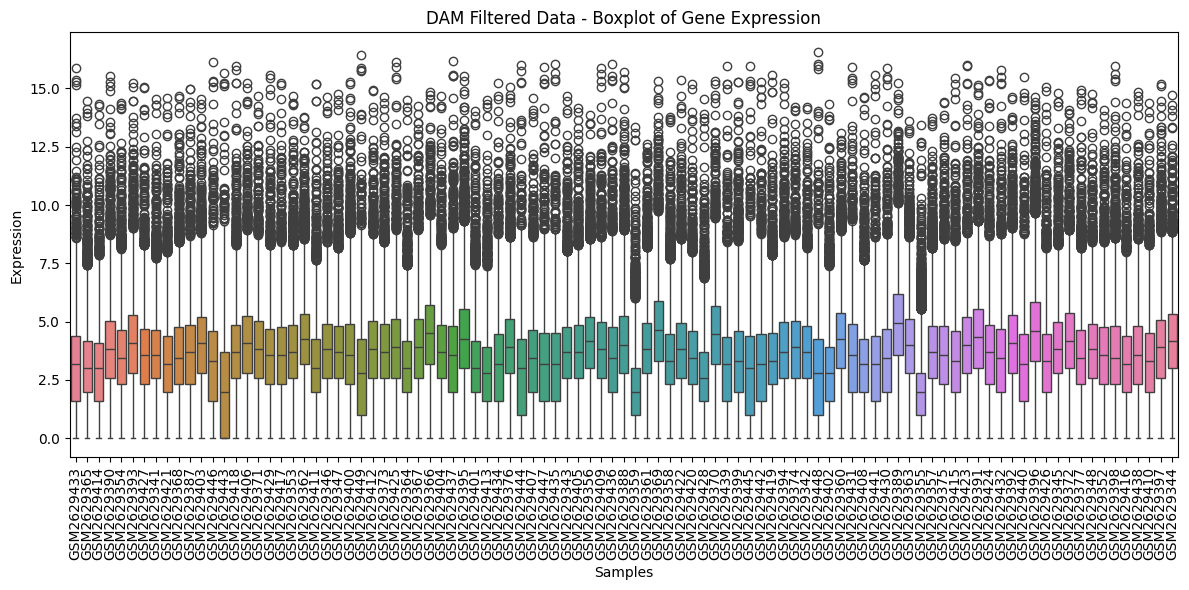

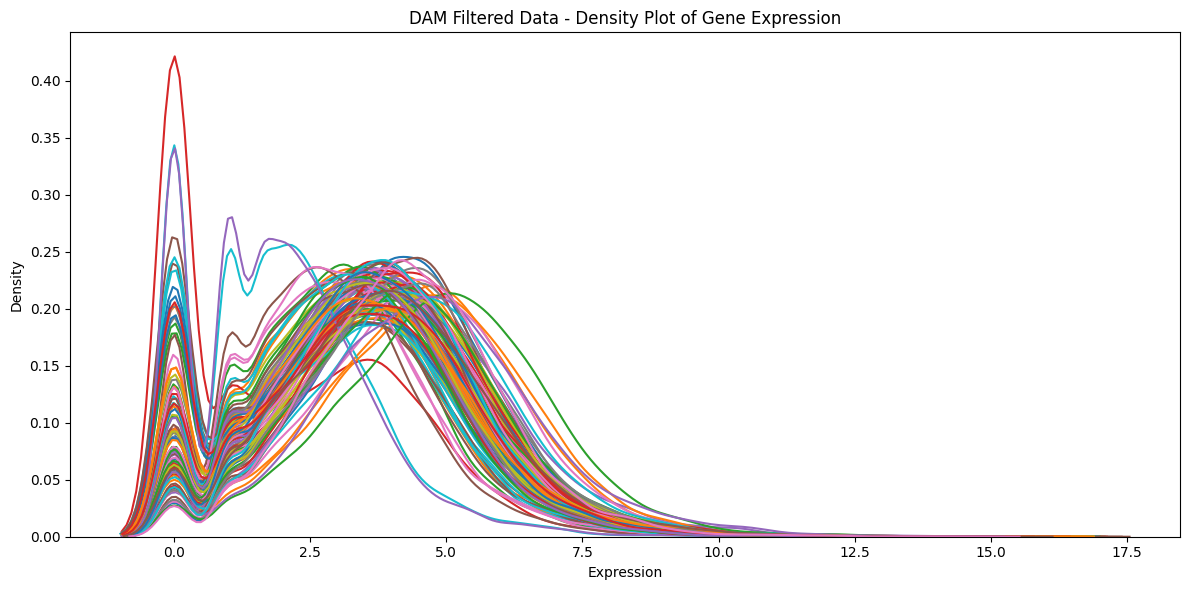

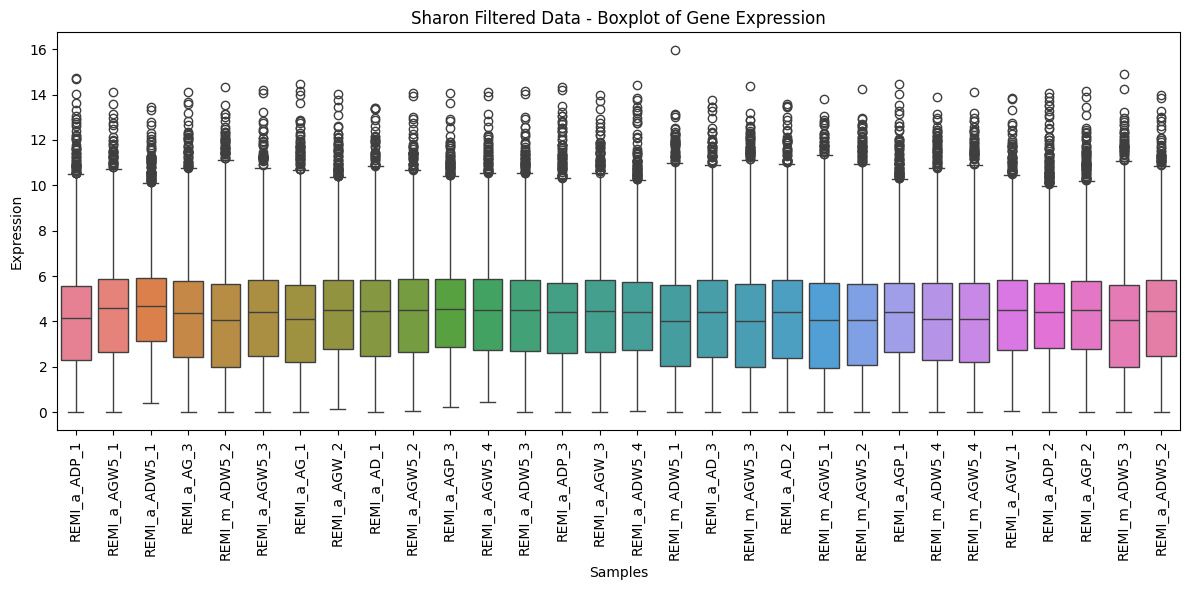

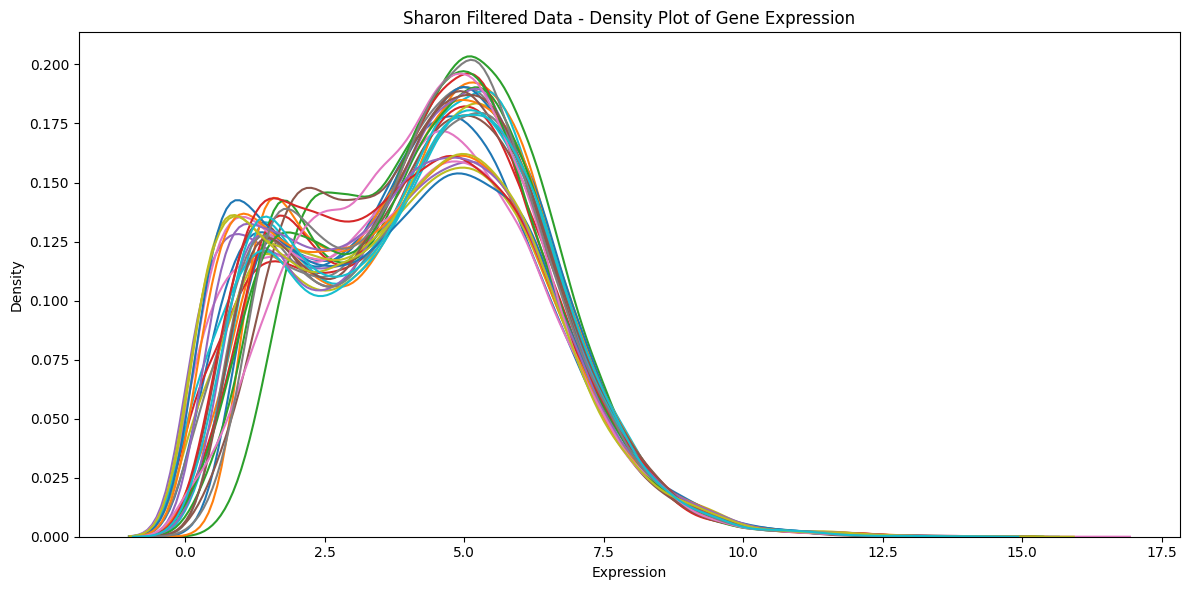

In [76]:
create_distribution_plots(dam_filtered, "DAM Filtered Data")
create_distribution_plots(sharon_filtered, "Sharon Filtered Data")

# Similarity

In [77]:
# Find common genes and subset data
common_genes = list(set(sharon_filtered.index) & set(dam_filtered.index))
sharon_common = sharon_filtered.loc[common_genes]
dam_common = dam_filtered.loc[common_genes]

In [78]:
dam_common.head()

,GSM2629433,GSM2629365,GSM2629414,GSM2629390,GSM2629354,GSM2629393,GSM2629427,GSM2629341,GSM2629421,GSM2629368,...,GSM2629372,GSM2629377,GSM2629348,GSM2629352,GSM2629398,GSM2629416,GSM2629438,GSM2629410,GSM2629397,GSM2629344
Cdk14,2.321928,3.169925,3.321928,2.807355,4.087463,4.169925,3.459432,2.000000,2.321928,3.807355,...,4.000000,4.459432,2.807355,3.000000,3.906891,2.000000,2.584963,2.584963,3.906891,3.584963
Arhgap9,3.000000,3.807355,4.247928,3.906891,4.392317,4.523562,3.700440,3.807355,3.459432,4.459432,...,4.584963,5.781360,4.169925,4.857981,4.087463,3.459432,4.321928,4.906891,3.584963,5.087463
Pop4,3.584963,3.000000,2.000000,0.000000,3.000000,3.169925,3.584963,2.807355,4.247928,2.321928,...,4.247928,3.807355,3.169925,3.321928,2.321928,3.459432,3.906891,2.321928,3.169925,4.087463
Znhit3,4.000000,2.321928,1.584963,1.000000,1.584963,3.584963,2.584963,3.000000,2.000000,2.000000,...,3.169925,3.459432,2.584963,2.321928,2.000000,2.000000,2.321928,3.000000,2.321928,3.584963
Tet2,2.584963,3.000000,3.169925,4.321928,3.000000,4.523562,3.807355,4.584963,2.807355,3.700440,...,3.459432,3.169925,4.392317,2.807355,3.906891,3.459432,3.321928,4.392317,4.321928,5.087463


In [79]:
sharon_common.head()

,REMI_a_ADP_1,REMI_a_AGW5_1,REMI_a_ADW5_1,REMI_a_AG_3,REMI_m_ADW5_2,REMI_a_AGW5_3,REMI_a_AG_1,REMI_a_AGW_2,REMI_a_AD_1,REMI_a_AGW5_2,...,REMI_m_AGW5_1,REMI_m_AGW5_2,REMI_a_AGP_1,REMI_m_ADW5_4,REMI_m_AGW5_4,REMI_a_AGW_1,REMI_a_ADP_2,REMI_a_AGP_2,REMI_m_ADW5_3,REMI_a_ADW5_2
Geneid,,,,,,,,,,,,,,,,,,,,,
Cdk14,4.174746,4.641964,4.960815,4.028235,4.677137,4.379792,3.604204,4.485429,4.613943,4.592095,...,4.571044,4.545465,4.341674,4.837078,4.710253,4.547708,4.579043,4.344449,4.664543,4.446123
Arhgap9,0.647541,0.581589,3.149801,0.372443,5.532275,0.974994,0.639747,3.253105,0.352513,1.184206,...,5.883984,5.542189,0.768238,5.806536,5.743626,2.787002,1.721962,1.953752,5.611412,0.670943
Pop4,6.288621,5.342047,5.052876,5.772205,4.012628,5.544135,5.754512,5.171597,5.329986,5.477324,...,3.909162,3.933729,5.827820,3.902652,3.926131,5.378335,5.781392,5.807440,3.971081,5.601155
Znhit3,4.354521,3.153612,3.315683,3.385159,2.606133,3.166389,3.946856,3.233405,3.102952,3.473402,...,2.782593,2.426602,3.619691,2.307373,2.322041,3.243637,4.783728,3.539333,2.596407,3.211778
Tet2,5.061743,6.050703,6.388434,5.270934,6.334159,5.744269,4.021812,4.978016,6.333322,5.931164,...,5.652022,5.789292,4.599708,6.727909,6.093952,5.500657,5.543185,5.085277,6.061707,6.290857


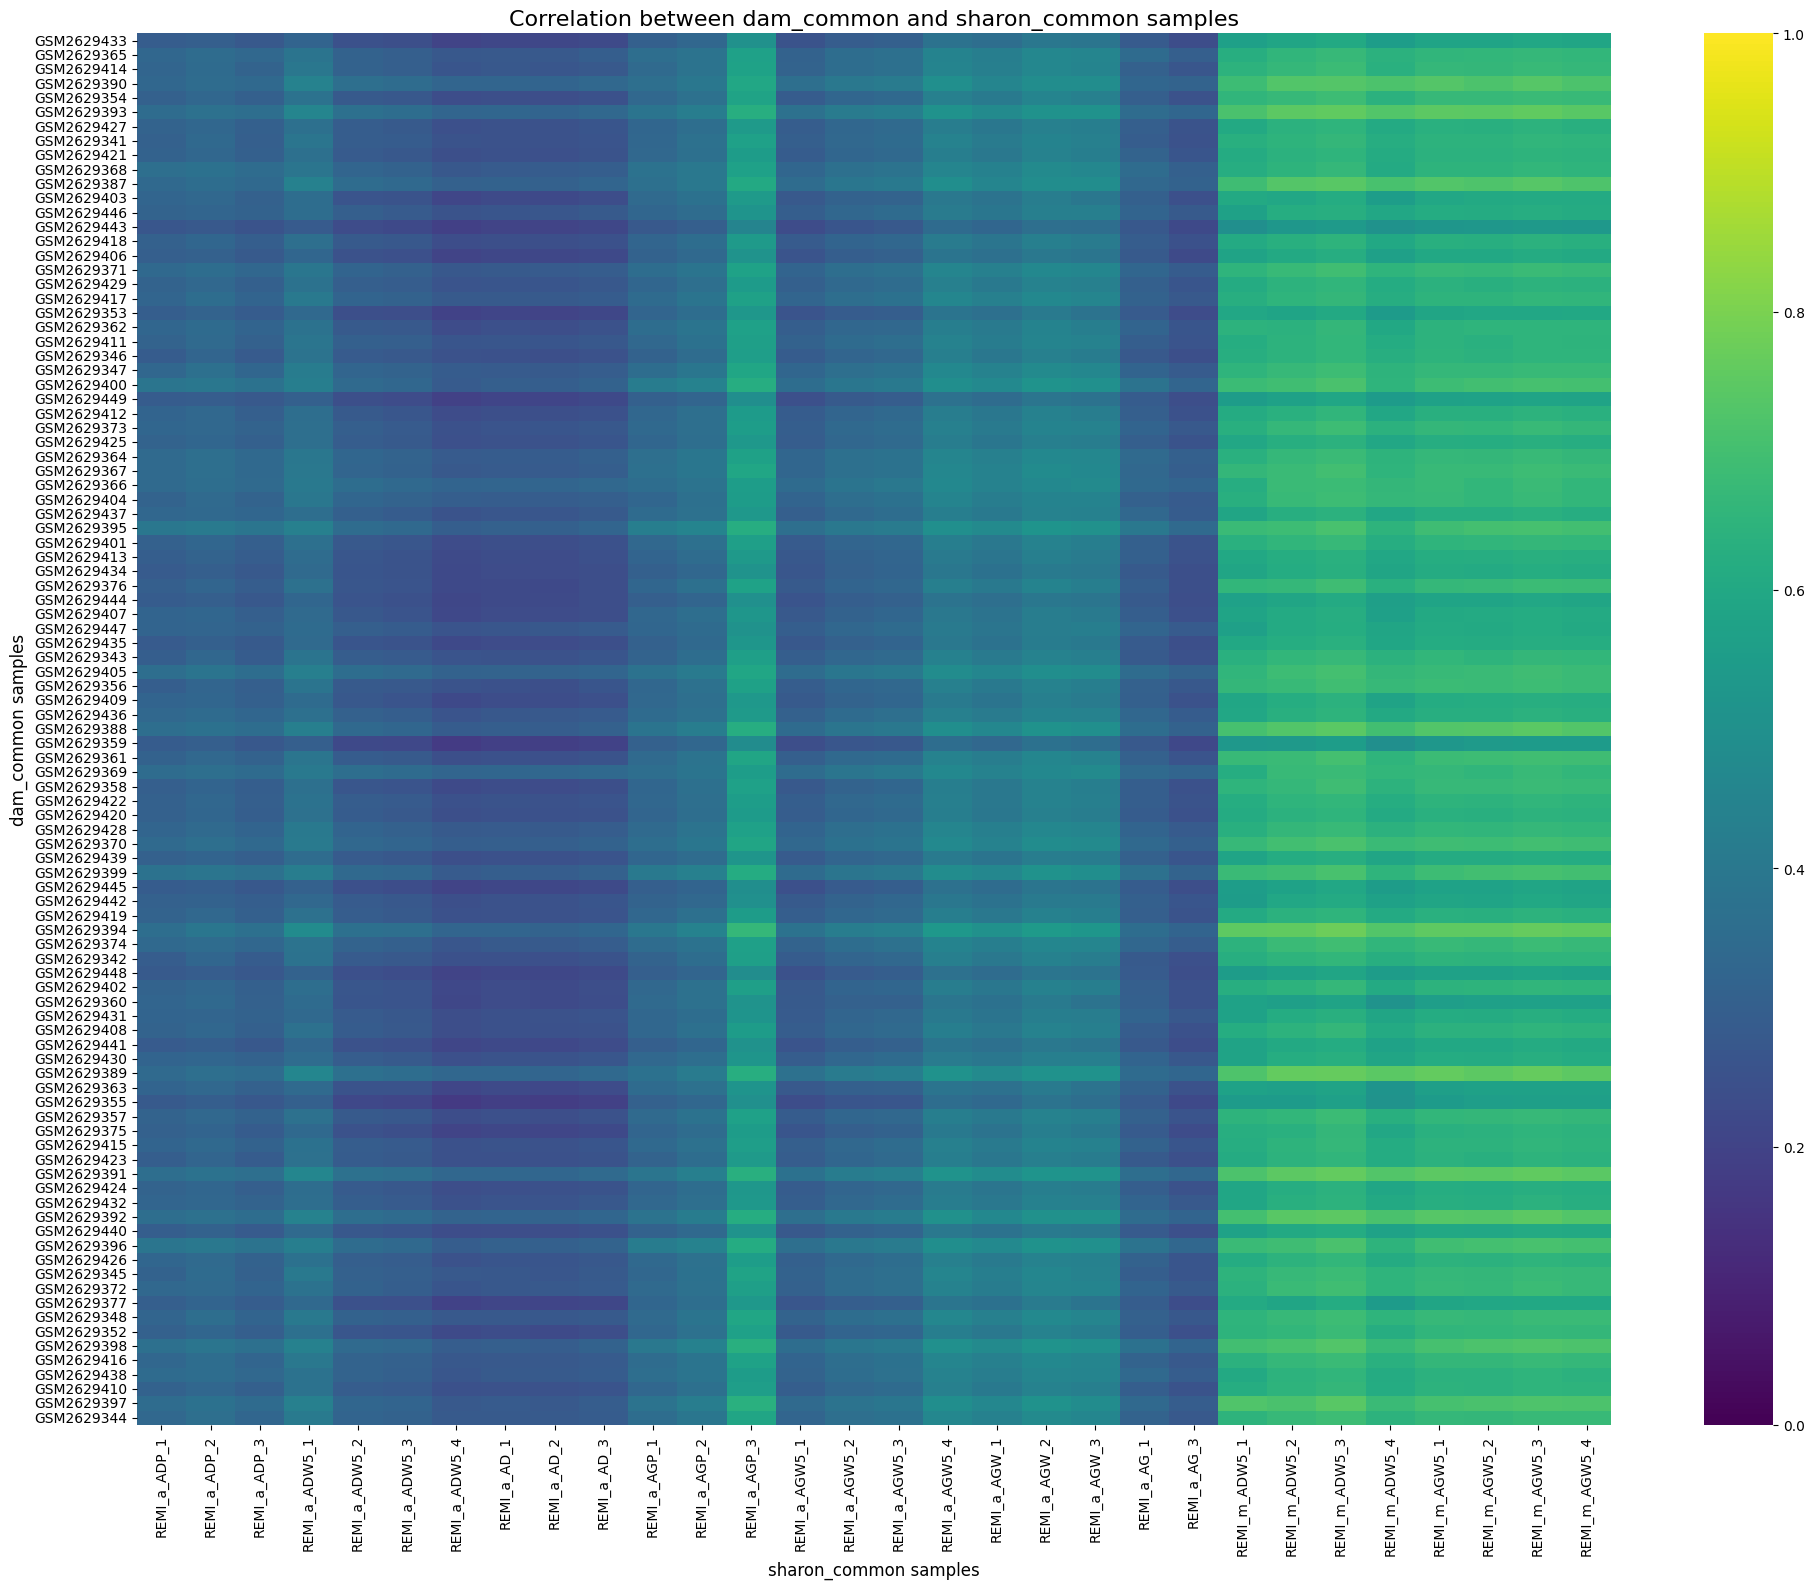

In [80]:
# Convert data to numeric, replacing any non-numeric values with NaN
dam_common = dam_common.apply(pd.to_numeric, errors='coerce')
sharon_common = sharon_common.apply(pd.to_numeric, errors='coerce')

# Sort the columns of sharon_common alphabetically
sharon_common = sharon_common.sort_index(axis=1)

# Calculate correlation matrix
correlation_matrix = pd.DataFrame(index=dam_common.columns, columns=sharon_common.columns)

for dam_col in dam_common.columns:
    for sharon_col in sharon_common.columns:
        dam_data = dam_common[dam_col].dropna()
        sharon_data = sharon_common[sharon_col].dropna()
        
        if len(dam_data) > 1 and len(sharon_data) > 1:
            correlation = np.corrcoef(dam_data, sharon_data)[0, 1]
            correlation_matrix.loc[dam_col, sharon_col] = correlation
        else:
            correlation_matrix.loc[dam_col, sharon_col] = np.nan

# Replace any remaining non-numeric values with NaN
correlation_matrix = correlation_matrix.apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(20, 16))

sns.heatmap(correlation_matrix, cmap='viridis', center=0.5, vmin=0, vmax=1, 
            xticklabels=True, yticklabels=True)

plt.title('Correlation between dam_common and sharon_common samples', fontsize=16)
plt.xlabel('sharon_common samples', fontsize=12)
plt.ylabel('dam_common samples', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Annotate experiments

In [81]:
# Load the metadata from the Excel file
metadata = pd.read_excel('/beegfs/scratch/ric.broccoli/kubacki.michal/GSE98969/data/metadata.xlsx', header=0)

# Display basic information about the metadata
print(metadata.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Treatment      97 non-null     object
 1   age            97 non-null     object
 2   region         97 non-null     object
 3   title          97 non-null     object
 4   geo_accession  97 non-null     object
 5   strain         97 non-null     object
 6   organ          97 non-null     object
dtypes: object(7)
memory usage: 5.4+ KB
None


In [82]:
metadata.head()

,Treatment,age,region,title,geo_accession,strain,organ
0,treatment: Alzheimer's disease,mouse age: 6 months,Whole brain,AB1442,GSM2629341,strain: 5XFAD,organ: Brain
1,treatment: Alzheimer's disease,mouse age: 6 months,Whole brain,AB1443,GSM2629342,strain: C57BL/6,organ: Brain
2,treatment: Alzheimer's disease,mouse age: 6 months,Whole brain,AB1444,GSM2629343,strain: C57BL/6,organ: Brain
3,treatment: Alzheimer's disease,mouse age: 6 months,Whole brain,AB1445,GSM2629344,strain: 5XFAD,organ: Brain
4,treatment: Alzheimer's disease,mouse age: 6 months,Whole brain,AB1446,GSM2629345,strain: C57BL/6,organ: Brain


In [83]:
# Remove prefixes from specified columns
metadata['Treatment'] = metadata['Treatment'].str.replace('treatment: ', '')
metadata['age'] = metadata['age'].str.replace('mouse age: ', '')
metadata['strain'] = metadata['strain'].str.replace('strain: ', '')
metadata['organ'] = metadata['organ'].str.replace('organ: ', '')

In [84]:
metadata.head()

,Treatment,age,region,title,geo_accession,strain,organ
0,Alzheimer's disease,6 months,Whole brain,AB1442,GSM2629341,5XFAD,Brain
1,Alzheimer's disease,6 months,Whole brain,AB1443,GSM2629342,C57BL/6,Brain
2,Alzheimer's disease,6 months,Whole brain,AB1444,GSM2629343,C57BL/6,Brain
3,Alzheimer's disease,6 months,Whole brain,AB1445,GSM2629344,5XFAD,Brain
4,Alzheimer's disease,6 months,Whole brain,AB1446,GSM2629345,C57BL/6,Brain


In [58]:
list(metadata.strain.unique())

['5XFAD', 'C57BL/6', 'SOD1', 'Trem2KO', 'Trem2KO_5XFAD']

In [86]:
dam_common.head()

,GSM2629433,GSM2629365,GSM2629414,GSM2629390,GSM2629354,GSM2629393,GSM2629427,GSM2629341,GSM2629421,GSM2629368,...,GSM2629372,GSM2629377,GSM2629348,GSM2629352,GSM2629398,GSM2629416,GSM2629438,GSM2629410,GSM2629397,GSM2629344
Cdk14,2.321928,3.169925,3.321928,2.807355,4.087463,4.169925,3.459432,2.000000,2.321928,3.807355,...,4.000000,4.459432,2.807355,3.000000,3.906891,2.000000,2.584963,2.584963,3.906891,3.584963
Arhgap9,3.000000,3.807355,4.247928,3.906891,4.392317,4.523562,3.700440,3.807355,3.459432,4.459432,...,4.584963,5.781360,4.169925,4.857981,4.087463,3.459432,4.321928,4.906891,3.584963,5.087463
Pop4,3.584963,3.000000,2.000000,0.000000,3.000000,3.169925,3.584963,2.807355,4.247928,2.321928,...,4.247928,3.807355,3.169925,3.321928,2.321928,3.459432,3.906891,2.321928,3.169925,4.087463
Znhit3,4.000000,2.321928,1.584963,1.000000,1.584963,3.584963,2.584963,3.000000,2.000000,2.000000,...,3.169925,3.459432,2.584963,2.321928,2.000000,2.000000,2.321928,3.000000,2.321928,3.584963
Tet2,2.584963,3.000000,3.169925,4.321928,3.000000,4.523562,3.807355,4.584963,2.807355,3.700440,...,3.459432,3.169925,4.392317,2.807355,3.906891,3.459432,3.321928,4.392317,4.321928,5.087463


In [94]:
geo_to_strain = dict(zip(metadata.geo_accession, metadata.strain))
strain = dam_common.rename(columns=geo_to_strain, inplace=False)
strain.head()

,5XFAD,5XFAD,5XFAD,Trem2KO,C57BL/6,Trem2KO_5XFAD,C57BL/6,5XFAD,C57BL/6,5XFAD,...,C57BL/6,C57BL/6,5XFAD,C57BL/6,Trem2KO_5XFAD,5XFAD,5XFAD,5XFAD,Trem2KO,5XFAD
Cdk14,2.321928,3.169925,3.321928,2.807355,4.087463,4.169925,3.459432,2.000000,2.321928,3.807355,...,4.000000,4.459432,2.807355,3.000000,3.906891,2.000000,2.584963,2.584963,3.906891,3.584963
Arhgap9,3.000000,3.807355,4.247928,3.906891,4.392317,4.523562,3.700440,3.807355,3.459432,4.459432,...,4.584963,5.781360,4.169925,4.857981,4.087463,3.459432,4.321928,4.906891,3.584963,5.087463
Pop4,3.584963,3.000000,2.000000,0.000000,3.000000,3.169925,3.584963,2.807355,4.247928,2.321928,...,4.247928,3.807355,3.169925,3.321928,2.321928,3.459432,3.906891,2.321928,3.169925,4.087463
Znhit3,4.000000,2.321928,1.584963,1.000000,1.584963,3.584963,2.584963,3.000000,2.000000,2.000000,...,3.169925,3.459432,2.584963,2.321928,2.000000,2.000000,2.321928,3.000000,2.321928,3.584963
Tet2,2.584963,3.000000,3.169925,4.321928,3.000000,4.523562,3.807355,4.584963,2.807355,3.700440,...,3.459432,3.169925,4.392317,2.807355,3.906891,3.459432,3.321928,4.392317,4.321928,5.087463


In [89]:
geo_to_age = dict(zip(metadata.geo_accession, metadata.age))
age = dam_common.rename(columns=geo_to_age, inplace=False)
age.head()

,6 months,6 months,6 months,6 months,80 days,6 months,6 months,6 months,6 months,9 months,...,7 weeks,20 months,6 months,80 days,6 months,6 months,6 months,6 months,6 months,6 months
Cdk14,2.321928,3.169925,3.321928,2.807355,4.087463,4.169925,3.459432,2.000000,2.321928,3.807355,...,4.000000,4.459432,2.807355,3.000000,3.906891,2.000000,2.584963,2.584963,3.906891,3.584963
Arhgap9,3.000000,3.807355,4.247928,3.906891,4.392317,4.523562,3.700440,3.807355,3.459432,4.459432,...,4.584963,5.781360,4.169925,4.857981,4.087463,3.459432,4.321928,4.906891,3.584963,5.087463
Pop4,3.584963,3.000000,2.000000,0.000000,3.000000,3.169925,3.584963,2.807355,4.247928,2.321928,...,4.247928,3.807355,3.169925,3.321928,2.321928,3.459432,3.906891,2.321928,3.169925,4.087463
Znhit3,4.000000,2.321928,1.584963,1.000000,1.584963,3.584963,2.584963,3.000000,2.000000,2.000000,...,3.169925,3.459432,2.584963,2.321928,2.000000,2.000000,2.321928,3.000000,2.321928,3.584963
Tet2,2.584963,3.000000,3.169925,4.321928,3.000000,4.523562,3.807355,4.584963,2.807355,3.700440,...,3.459432,3.169925,4.392317,2.807355,3.906891,3.459432,3.321928,4.392317,4.321928,5.087463


In [90]:
geo_to_treatment = dict(zip(metadata.geo_accession, metadata.Treatment))
treatment = dam_common.rename(columns=geo_to_treatment, inplace=False)
treatment.head()

,Alzheimer's disease,Alzheimer's disease,Alzheimer's disease,Alzheimer's disease,ALS,Alzheimer's disease,Alzheimer's disease,Alzheimer's disease,Alzheimer's disease,Alzheimer's disease,...,Aging,Aging,Alzheimer's disease,ALS,Alzheimer's disease,Alzheimer's disease,Alzheimer's disease,Alzheimer's disease,Alzheimer's disease,Alzheimer's disease
Cdk14,2.321928,3.169925,3.321928,2.807355,4.087463,4.169925,3.459432,2.000000,2.321928,3.807355,...,4.000000,4.459432,2.807355,3.000000,3.906891,2.000000,2.584963,2.584963,3.906891,3.584963
Arhgap9,3.000000,3.807355,4.247928,3.906891,4.392317,4.523562,3.700440,3.807355,3.459432,4.459432,...,4.584963,5.781360,4.169925,4.857981,4.087463,3.459432,4.321928,4.906891,3.584963,5.087463
Pop4,3.584963,3.000000,2.000000,0.000000,3.000000,3.169925,3.584963,2.807355,4.247928,2.321928,...,4.247928,3.807355,3.169925,3.321928,2.321928,3.459432,3.906891,2.321928,3.169925,4.087463
Znhit3,4.000000,2.321928,1.584963,1.000000,1.584963,3.584963,2.584963,3.000000,2.000000,2.000000,...,3.169925,3.459432,2.584963,2.321928,2.000000,2.000000,2.321928,3.000000,2.321928,3.584963
Tet2,2.584963,3.000000,3.169925,4.321928,3.000000,4.523562,3.807355,4.584963,2.807355,3.700440,...,3.459432,3.169925,4.392317,2.807355,3.906891,3.459432,3.321928,4.392317,4.321928,5.087463


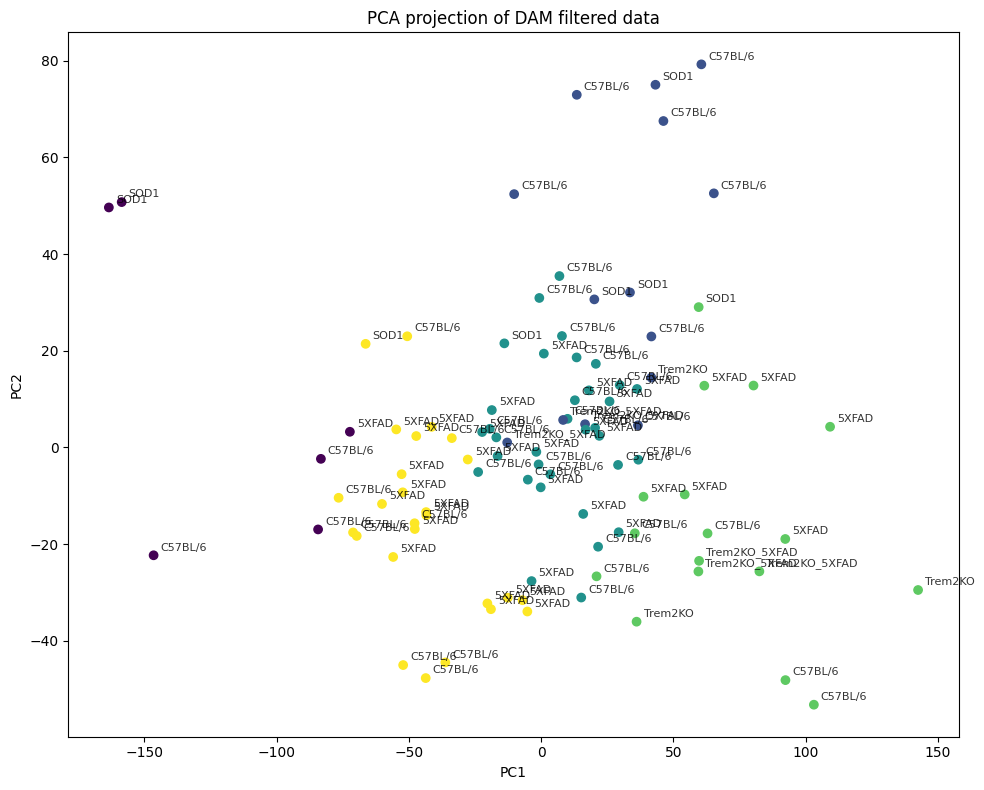

In [93]:
# Perform PCA on the transposed data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(strain.T)

# Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)  
cluster_labels = kmeans.fit_predict(strain.T)

# Create a scatter plot of the PCA results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis')
plt.title('PCA projection of DAM filtered data')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Add a colorbar legend
# plt.colorbar(scatter, label='Cluster')

# Add sample labels to the plot
for i, sample in enumerate(strain.columns):
    plt.annotate(sample, (pca_result[i, 0], pca_result[i, 1]), 
                 xytext=(5, 2), textcoords='offset points', ha='left', va='bottom',
                 fontsize=8, alpha=0.8)

plt.tight_layout()
plt.show()

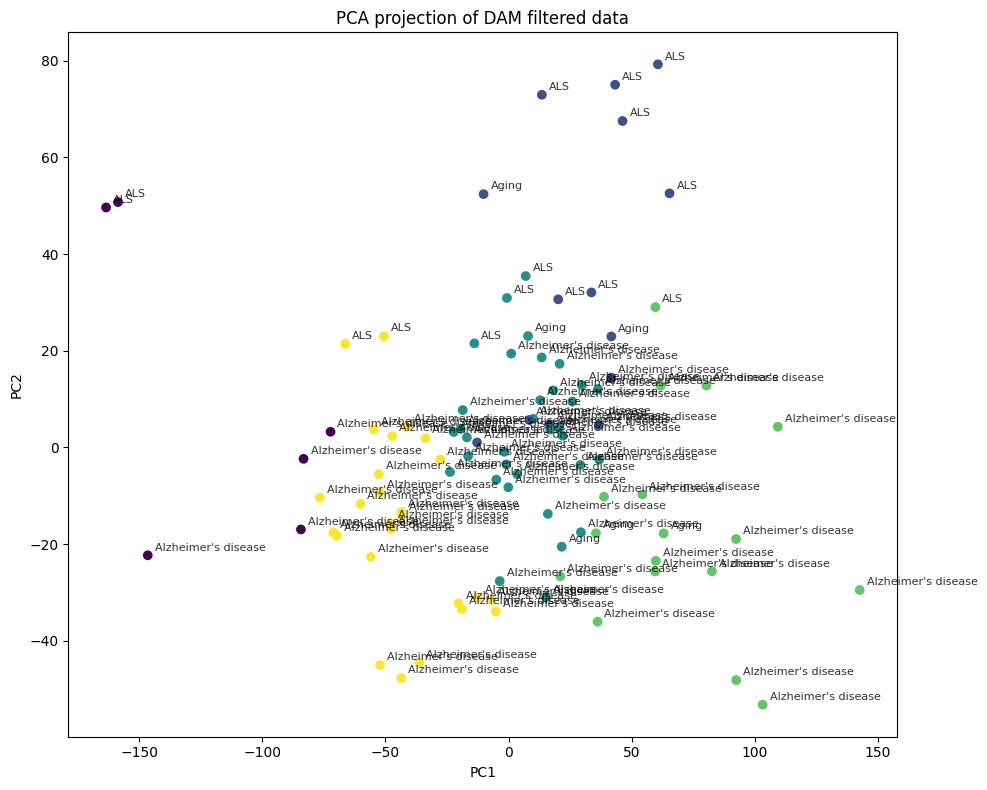

In [95]:
# Perform PCA on the transposed data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(treatment.T)

# Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)  
cluster_labels = kmeans.fit_predict(treatment.T)

# Create a scatter plot of the PCA results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis')
plt.title('PCA projection of DAM filtered data')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Add a colorbar legend
# plt.colorbar(scatter, label='Cluster')

# Add sample labels to the plot
for i, sample in enumerate(treatment.columns):
    plt.annotate(sample, (pca_result[i, 0], pca_result[i, 1]), 
                 xytext=(5, 2), textcoords='offset points', ha='left', va='bottom',
                 fontsize=8, alpha=0.8)

plt.tight_layout()
plt.show()

In [99]:
# Import necessary libraries
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Perform PCA on the transposed data
pca = PCA(n_components=3)
pca_result = pca.fit_transform(treatment.T)

# Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)  
cluster_labels = kmeans.fit_predict(treatment.T)

# Create an interactive 3D scatter plot
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])

scatter = go.Scatter3d(
    x=pca_result[:, 0],
    y=pca_result[:, 1],
    z=pca_result[:, 2],
    mode='markers+text',
    marker=dict(
        size=5,
        color=cluster_labels,
        colorscale='Viridis',
        opacity=0.8
    ),
    text=treatment.columns,
    hoverinfo='text'
)

fig.add_trace(scatter)

fig.update_layout(
    title='3D PCA projection of DAM filtered data',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    width=900,
    height=700,
)

fig.show()

# Filter Mouse_ID

In [100]:
strain = strain.loc[:, ~strain.columns.str.startswith('GSM')]
strain.head()

,5XFAD,5XFAD,5XFAD,Trem2KO,C57BL/6,Trem2KO_5XFAD,C57BL/6,5XFAD,C57BL/6,5XFAD,...,C57BL/6,C57BL/6,5XFAD,C57BL/6,Trem2KO_5XFAD,5XFAD,5XFAD,5XFAD,Trem2KO,5XFAD
Cdk14,2.321928,3.169925,3.321928,2.807355,4.087463,4.169925,3.459432,2.000000,2.321928,3.807355,...,4.000000,4.459432,2.807355,3.000000,3.906891,2.000000,2.584963,2.584963,3.906891,3.584963
Arhgap9,3.000000,3.807355,4.247928,3.906891,4.392317,4.523562,3.700440,3.807355,3.459432,4.459432,...,4.584963,5.781360,4.169925,4.857981,4.087463,3.459432,4.321928,4.906891,3.584963,5.087463
Pop4,3.584963,3.000000,2.000000,0.000000,3.000000,3.169925,3.584963,2.807355,4.247928,2.321928,...,4.247928,3.807355,3.169925,3.321928,2.321928,3.459432,3.906891,2.321928,3.169925,4.087463
Znhit3,4.000000,2.321928,1.584963,1.000000,1.584963,3.584963,2.584963,3.000000,2.000000,2.000000,...,3.169925,3.459432,2.584963,2.321928,2.000000,2.000000,2.321928,3.000000,2.321928,3.584963
Tet2,2.584963,3.000000,3.169925,4.321928,3.000000,4.523562,3.807355,4.584963,2.807355,3.700440,...,3.459432,3.169925,4.392317,2.807355,3.906891,3.459432,3.321928,4.392317,4.321928,5.087463


After filtering - strain shape: (9067, 97)
After filtering - sharon_common shape: (9067, 30)


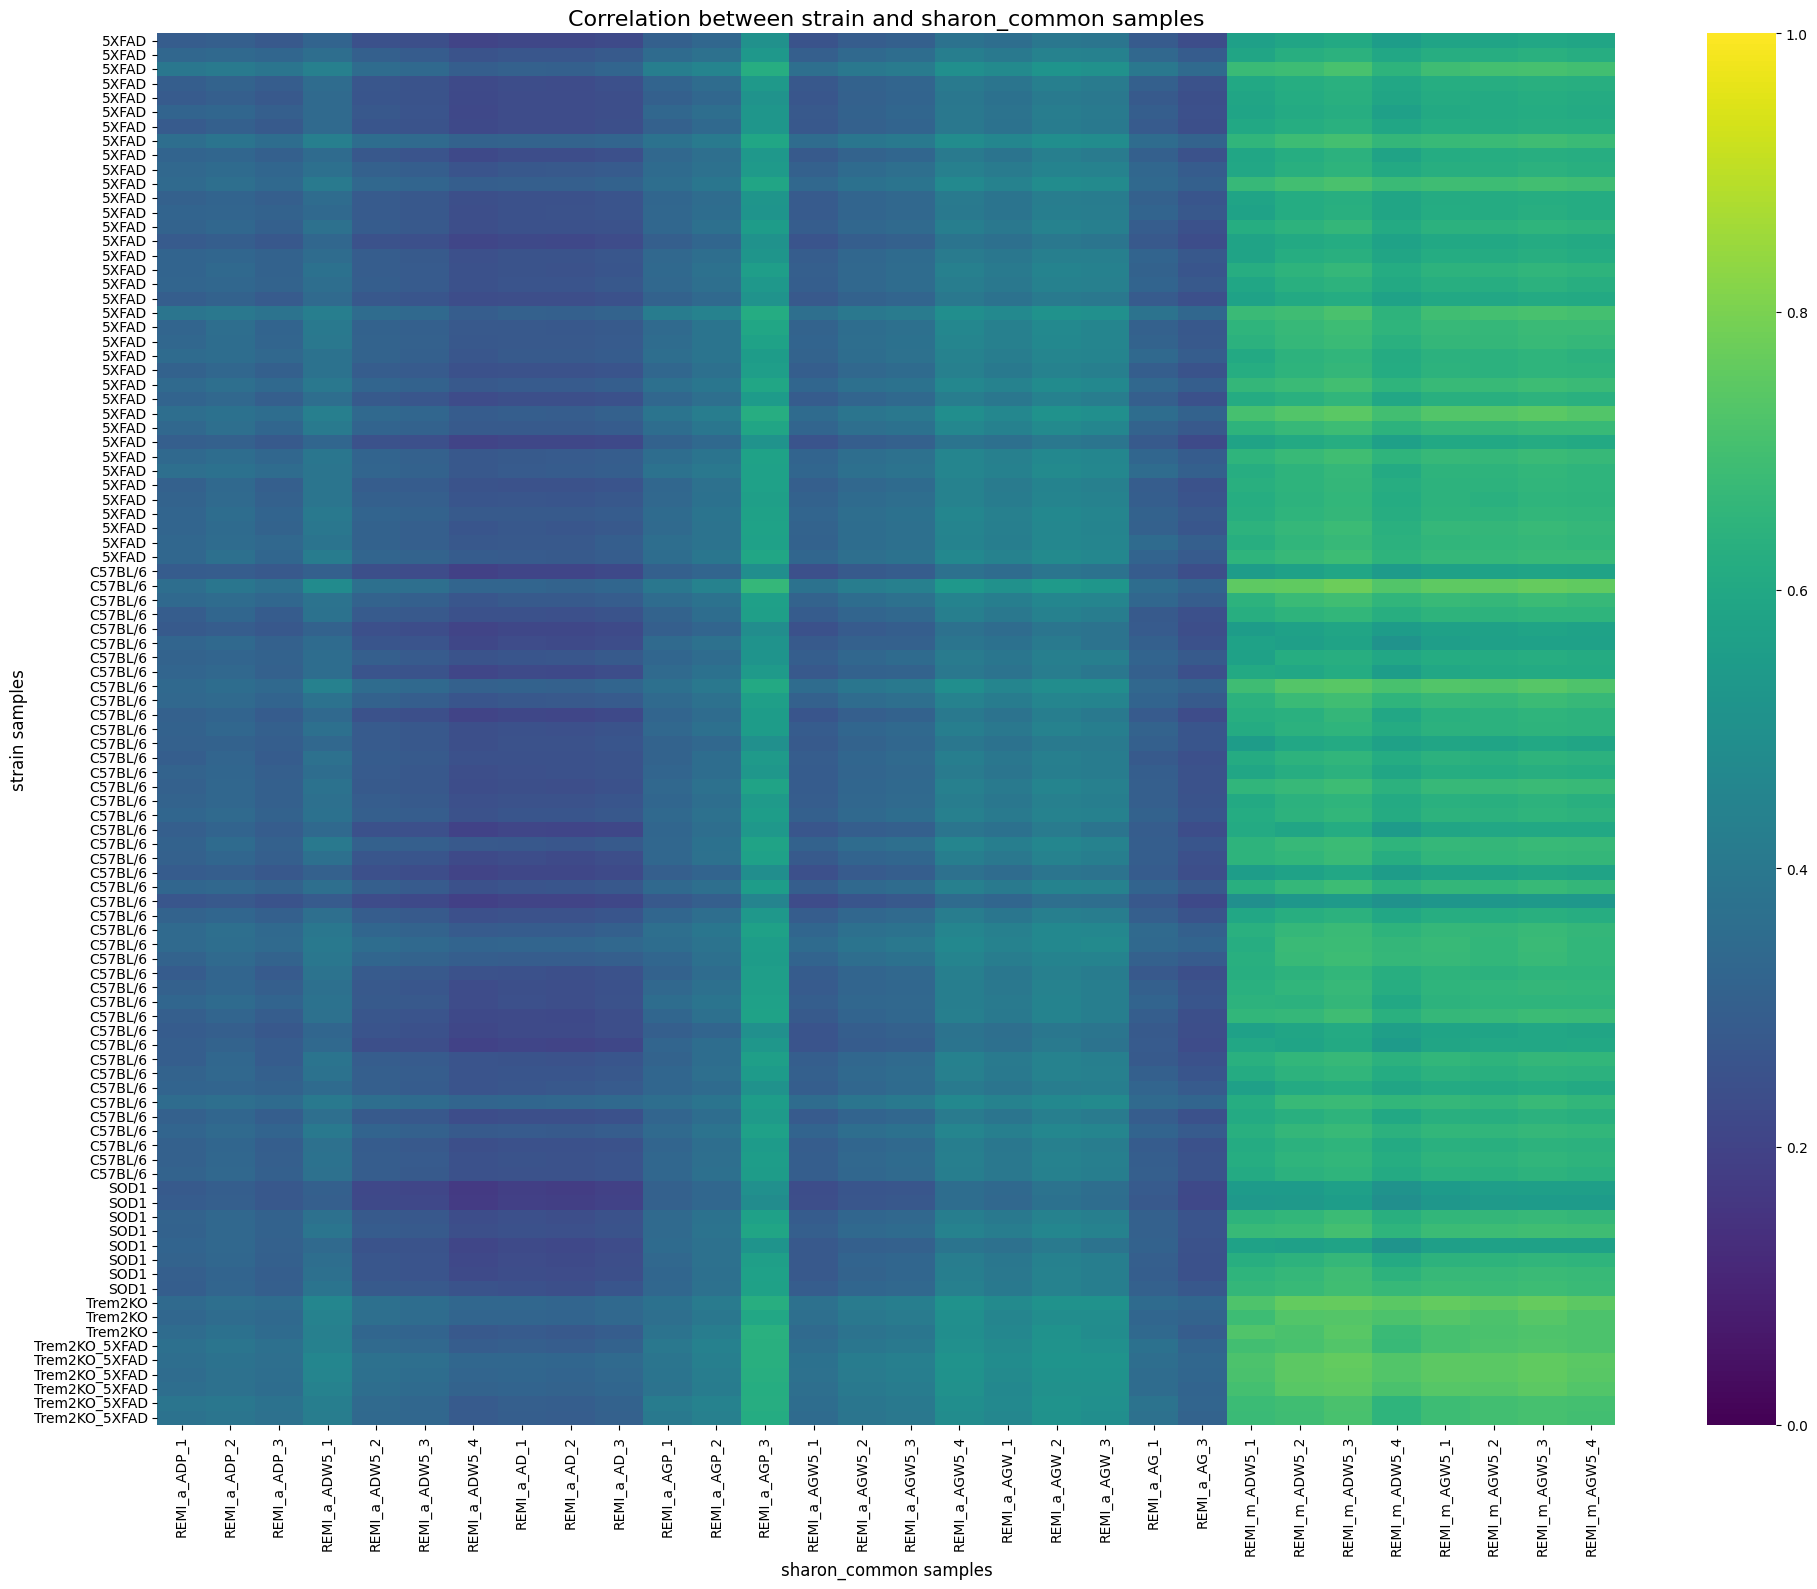

In [101]:
# Find common genes and subset data
common_genes = list(set(sharon_filtered.index) & set(strain.index))
sharon_common = sharon_filtered.loc[common_genes].reset_index(drop=True)
strain = strain.loc[common_genes]

print("After filtering - strain shape:", strain.shape)
print("After filtering - sharon_common shape:", sharon_common.shape)

# Convert data to numeric, replacing any non-numeric values with NaN
strain = strain.apply(pd.to_numeric, errors='coerce')
sharon_common = sharon_common.apply(pd.to_numeric, errors='coerce')

# Sort the columns of sharon_common alphabetically
sharon_common = sharon_common.sort_index(axis=1)
strain = strain.sort_index(axis=1)

# Prepare data for correlation
dam_data = strain.values.T
sharon_data = sharon_common.values.T

# Calculate correlation matrix efficiently
correlation_matrix = np.empty((dam_data.shape[0], sharon_data.shape[0]))
correlation_matrix.fill(np.nan)

for i, d in enumerate(dam_data):
    for j, s in enumerate(sharon_data):
        mask = ~np.isnan(d) & ~np.isnan(s)
        if np.sum(mask) > 1:
            correlation_matrix[i, j] = np.corrcoef(d[mask], s[mask])[0, 1]

# Convert to DataFrame
correlation_matrix = pd.DataFrame(correlation_matrix, 
                                  index=strain.columns, 
                                  columns=sharon_common.columns)

# Plotting
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, cmap='viridis', center=0.5, vmin=0, vmax=1, 
            xticklabels=True, yticklabels=True)

plt.title('Correlation between strain and sharon_common samples', fontsize=16)
plt.xlabel('sharon_common samples', fontsize=12)
plt.ylabel('strain samples', fontsize=12)

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

After filtering - treatment shape: (9067, 97)
After filtering - sharon_common shape: (9067, 30)


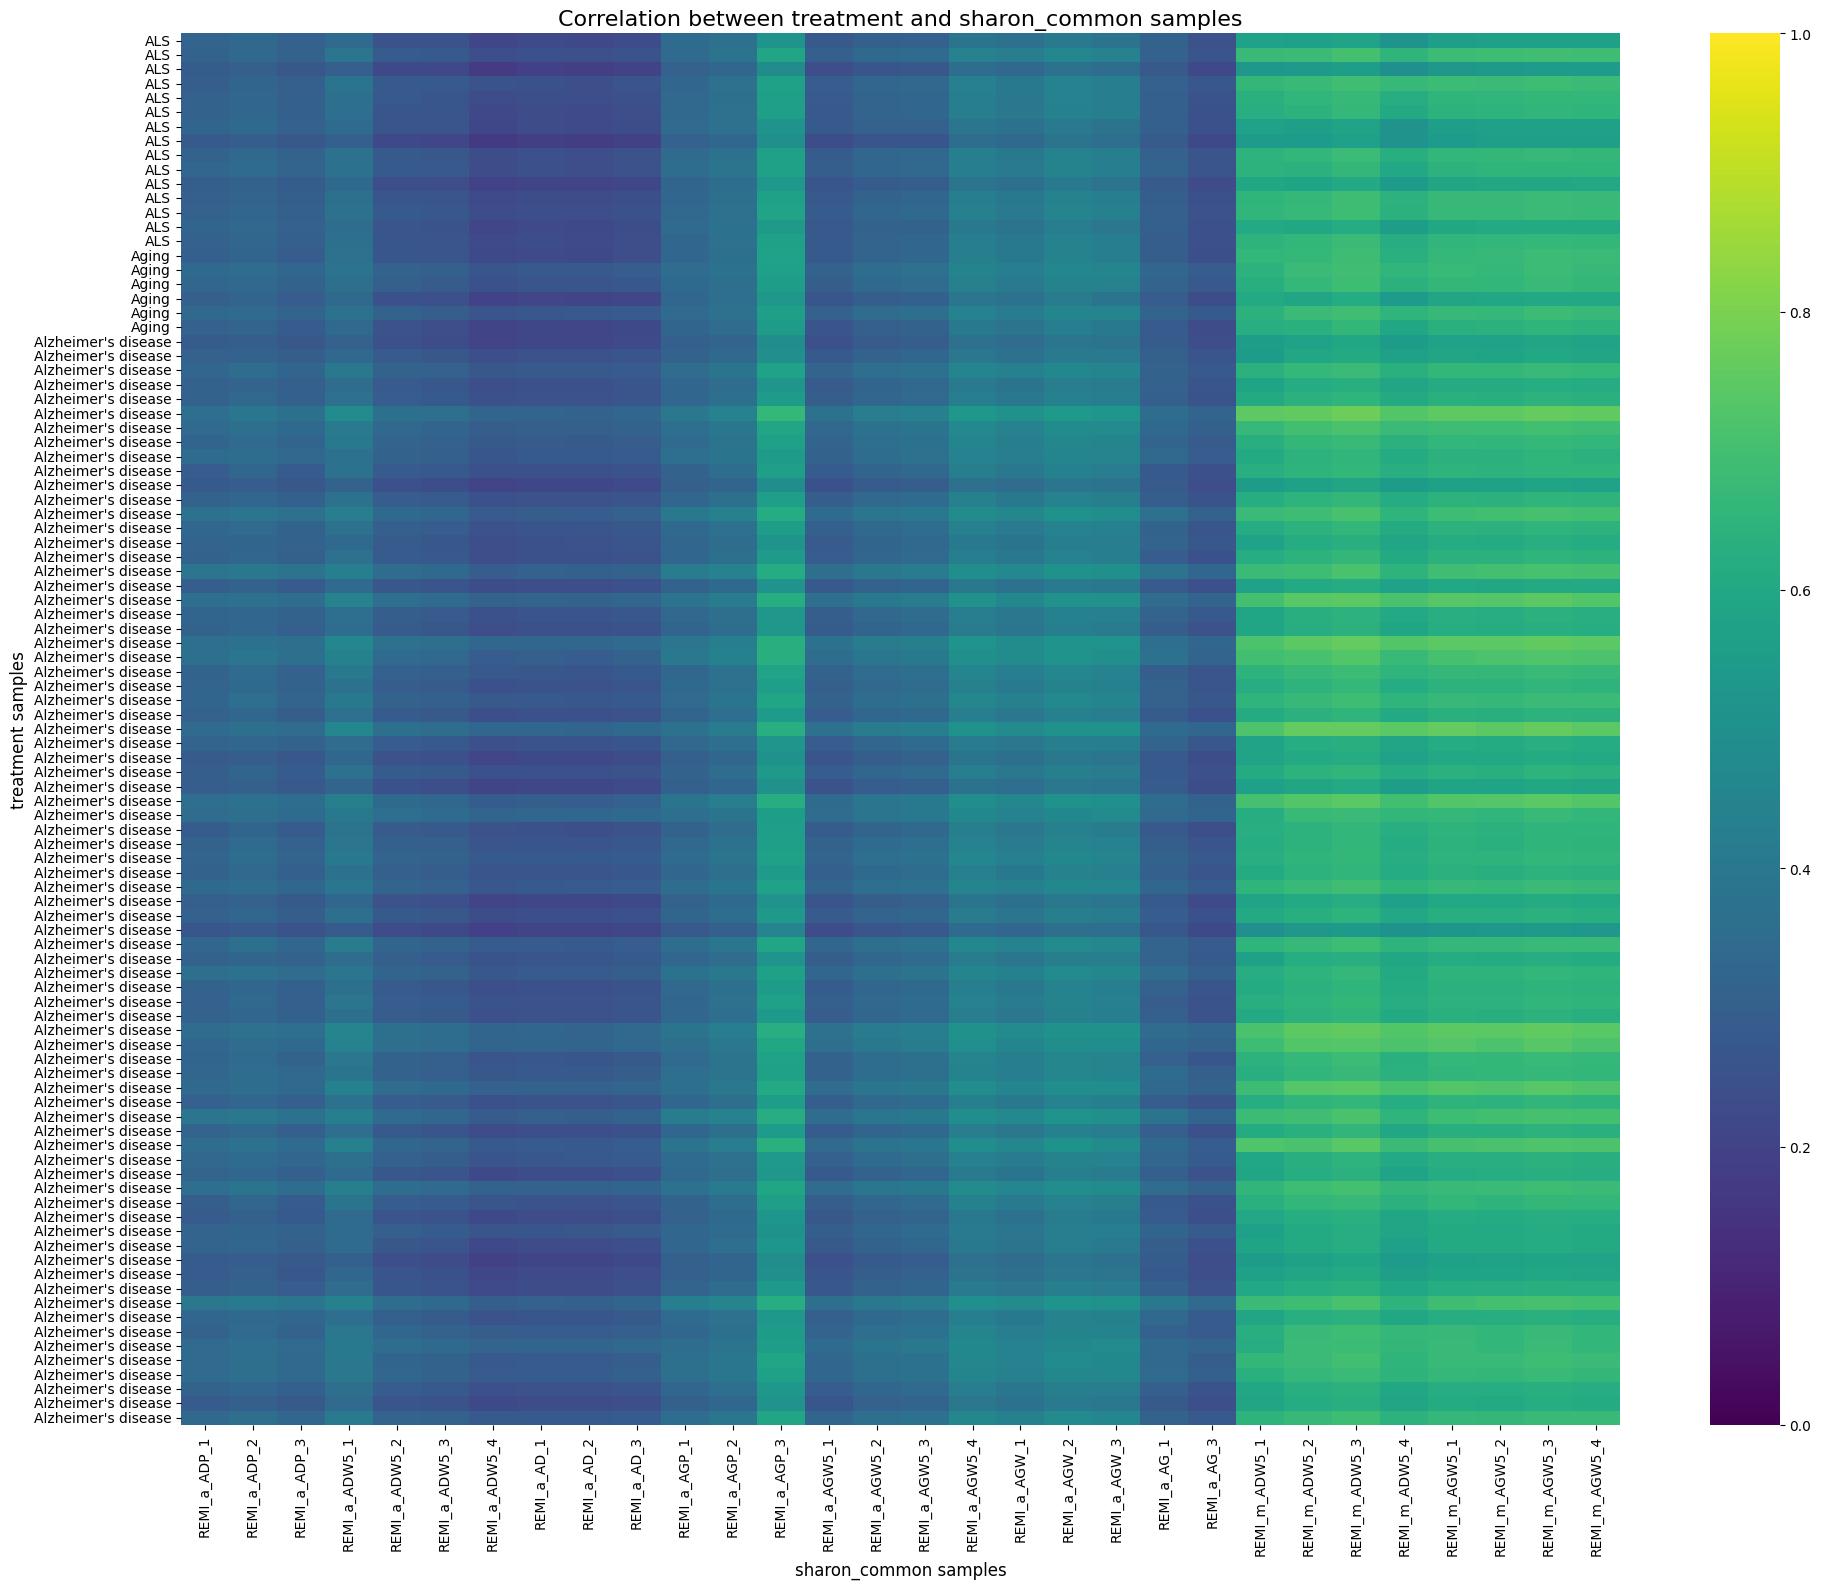

In [102]:
# Find common genes and subset data
common_genes = list(set(sharon_filtered.index) & set(treatment.index))
sharon_common = sharon_filtered.loc[common_genes].reset_index(drop=True)
treatment = treatment.loc[common_genes]

print("After filtering - treatment shape:", treatment.shape)
print("After filtering - sharon_common shape:", sharon_common.shape)

# Convert data to numeric, replacing any non-numeric values with NaN
treatment = treatment.apply(pd.to_numeric, errors='coerce')
sharon_common = sharon_common.apply(pd.to_numeric, errors='coerce')

# Sort the columns of sharon_common alphabetically
sharon_common = sharon_common.sort_index(axis=1)
treatment = treatment.sort_index(axis=1)

# Prepare data for correlation
dam_data = treatment.values.T
sharon_data = sharon_common.values.T

# Calculate correlation matrix efficiently
correlation_matrix = np.empty((dam_data.shape[0], sharon_data.shape[0]))
correlation_matrix.fill(np.nan)

for i, d in enumerate(dam_data):
    for j, s in enumerate(sharon_data):
        mask = ~np.isnan(d) & ~np.isnan(s)
        if np.sum(mask) > 1:
            correlation_matrix[i, j] = np.corrcoef(d[mask], s[mask])[0, 1]

# Convert to DataFrame
correlation_matrix = pd.DataFrame(correlation_matrix, 
                                  index=treatment.columns, 
                                  columns=sharon_common.columns)

# Plotting
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, cmap='viridis', center=0.5, vmin=0, vmax=1, 
            xticklabels=True, yticklabels=True)

plt.title('Correlation between treatment and sharon_common samples', fontsize=16)
plt.xlabel('sharon_common samples', fontsize=12)
plt.ylabel('treatment samples', fontsize=12)

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()